In [1]:
import numpy as np
import pandas as pd

In [2]:
import operator

from copy import copy

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv("../data/train.txt", sep='\t', header=None, names=["users", "items", "rank"])
df.head()

,users,items,rank
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [6]:
df["rank"].unique()

array([5, 3, 4, 1, 2])

In [7]:
n_users = df["users"].max()
n_items = df["items"].max()

In [8]:
df[["users", "items"]] -= 1
df.head()

,users,items,rank
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,3
4,0,4,3


In [9]:
def score(matrix, values):
    y_pred = [matrix[user, item] for user, item, rank in values]
    y_true = map(operator.itemgetter(2), values)
    return mean_squared_error(y_true, y_pred)

In [10]:
def iter_step(weights, bias, C, alpha):
    weights_, bias_ = copy(weights), copy(bias)
    
    global n_users
    global n_items
    global matrix
    
    for user in range(n_users):
        Q = weights_["items"]
        Q = np.hstack((np.ones(shape=(n_items, 1), dtype=float), Q))
        r = r_matrix[user, :].reshape(-1) - bias_["items"]
        G = np.diag(G_matrix[user, :]) # np.diag(1.0 + alpha * r)
        
        A = np.dot(Q.T, np.dot(G, Q)) + C * np.eye(Q.shape[1])
        b = np.dot(Q.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["users"][user], bias_["users"][user] = solution[1:], solution[0]
        
    for item in range(n_items):
        P = weights_["users"]
        P = np.hstack((np.ones(shape=(n_users, 1), dtype=float), P))
        r = r_matrix[:, item].reshape(-1) - bias_["users"]
        G = np.diag(G_matrix[:, item]) # np.diag(1.0 + alpha * r)
        
        A = np.dot(P.T, np.dot(G, P)) + C * np.eye(P.shape[1])
        b = np.dot(P.T, np.dot(G, r))
        
        solution = np.linalg.solve(A, b)
        weights_["items"][item], bias_["items"][item] = solution[1:], solution[0]
        
    return weights_, bias_

In [11]:
index = np.random.permutation(df.shape[0])
beta = int(0.8 * len(index))

df_train, df_valid = df.iloc[index[:beta]], df.iloc[index[beta:]]

In [12]:
df_grouped = {cat : df_train.groupby(by=cat) for cat in ["users", "items"]}

In [13]:
r_matrix = np.zeros(shape=(n_users, n_items), dtype=float)
for user, item, rank in df_train.values:
    r_matrix[user, item] = rank
    
G_matrix = (r_matrix > 0).astype(float)
G_matrix += (G_matrix == 0).astype(float) * 0.01

for user, group in df_grouped["users"]:
    mask = r_matrix[user, :] == 0
    r_matrix[user, mask] = group["rank"].mean()

In [14]:
results = dict()

In [36]:
C = 5.0
n_features = 2
alpha = 0.13

In [37]:
weights = dict()
weights["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, n_features))
weights["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, n_features))

bias = dict()
bias["users"] = np.random.normal(loc=0.0, scale=0.01, size=(n_users, ))
bias["items"] = np.random.normal(loc=0.0, scale=0.01, size=(n_items, ))
    
scores = []
    
n_iters = 100

for i in range(n_iters):
    weigths, bias = iter_step(weights, bias, C, alpha)
            
    matrix = bias["users"].reshape(-1, 1) + bias["items"].reshape(1, -1) \
            + np.dot(weights["users"], weights["items"].T)
    scores.append(
        (score(matrix, df_train.values),
         score(matrix, df_valid.values))
    )
        
    print "\r{} of {} iters passed...".format(i + 1, n_iters),

100 of 100 iters passed...


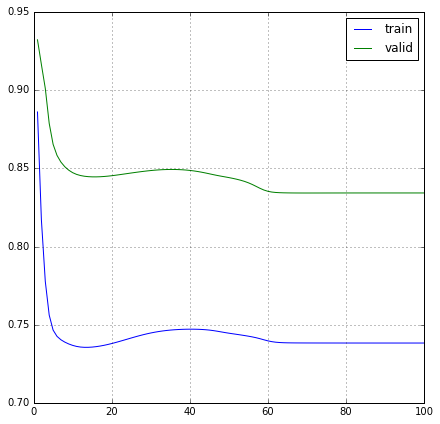

In [38]:
offset = 0

plt.figure(figsize=(7, 7))
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(0), scores)[offset:], label="train")
plt.plot(range(offset+1, len(scores)+1), map(operator.itemgetter(1), scores)[offset:], label="valid")
plt.legend()
plt.grid()

In [39]:
np.argsort(map(operator.itemgetter(1), scores))

array([69, 70, 68, 71, 72, 67, 73, 74, 75, 76, 66, 77, 78, 79, 80, 81, 99,
       98, 97, 82, 96, 95, 83, 94, 93, 84, 92, 91, 85, 90, 86, 89, 87, 88,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 15, 14, 16, 13, 17, 12, 47, 18, 19, 11, 46, 20, 21, 45, 10, 22,
       44, 23, 24, 43,  9, 25, 42, 26, 41, 27, 28, 40, 29, 39, 30,  8, 38,
       31, 37, 32, 36, 33, 35, 34,  7,  6,  5,  4,  3,  2,  1,  0])

In [40]:
np.min(map(operator.itemgetter(1), scores))

0.8342771620361864

In [41]:
a = map(operator.itemgetter(1), scores)
results[(C, n_features, alpha)] = (np.argmin(a), np.min(a))

In [42]:
results

{(5.0, 2, 0.13): (69, 0.8342771620361864),
 (5.0, 4, 0.13): (96, 0.82848907802864247),
 (5.0, 4, 0.14): (76, 0.8293373724212002),
 (5.0, 4, 0.15): (24, 0.83359095433689323)}